In [1]:
import matplotlib.pyplot as plt
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np



%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.input import Normalize, InputStandardize
from botorch.models.transforms.outcome import Standardize
from botorch.fit import fit_gpytorch_mll

In [3]:
import yaml
import pandas as pd

# training yaml file setup
config1 = yaml.safe_load(open("20220806_two_bunch_FEL_with_kicker_2.yaml"))
data1 = pd.DataFrame(config1['data'])
data1.index = map(int, data1.index)
data1 = data1.sort_index(axis=0)

# testing yaml file setup
config2 = yaml.safe_load(open("20220806_two_bunch_FEL_with_kicker_3.yaml"))
data2 = pd.DataFrame(config2['data'])
data2.index = map(int, data2.index)
data2 = data2.sort_index(axis=0)

In [4]:
# training data for x tensor changing MKBs & TDLYs with y tensor being obj_sum
# different yaml files will substitute different PVs here
xtorch_tensor1 = torch.tensor(data1['MKB:SYS0:3:VAL'].values)
xtorch_tensor2 = torch.tensor(data1['MKB:SYS0:4:VAL'].values)
xtorch_tensor3 = torch.tensor(data1['TDLY:LI21:1:ADelaySet'].values)
xtorch_tensor4 = torch.tensor(data1['TDLY:LI21:1:CDelaySet'].values)

xtorch_tensor1 = xtorch_tensor1.reshape(-1,1)
xtorch_tensor2 = xtorch_tensor2.reshape(-1,1)
xtorch_tensor3 = xtorch_tensor3.reshape(-1,1)
xtorch_tensor4 = xtorch_tensor4.reshape(-1,1)
xtorch_tensor1.shape

torch.Size([57, 1])

In [5]:
xtorch_tensor = torch.cat( (xtorch_tensor1, xtorch_tensor2, xtorch_tensor3, xtorch_tensor4), dim=1)
ytorch_tensor = torch.tensor(data1['obj_sum'].values)

In [6]:
# testing data for x tensor changing MKBs & TDLYs with y tensor being obj_sum
# different yaml files will substitute different PVs here
x2torch_tensor1 = torch.tensor(data2['MKB:SYS0:3:VAL'].values)
x2torch_tensor2 = torch.tensor(data2['MKB:SYS0:4:VAL'].values)
x2torch_tensor3 = torch.tensor(data2['TDLY:LI21:1:ADelaySet'].values)
x2torch_tensor4 = torch.tensor(data2['TDLY:LI21:1:CDelaySet'].values)

x2torch_tensor1 = x2torch_tensor1.reshape(-1,1)
x2torch_tensor2 = x2torch_tensor2.reshape(-1,1)
x2torch_tensor3 = x2torch_tensor3.reshape(-1,1)
x2torch_tensor4 = x2torch_tensor4.reshape(-1,1)

In [7]:
xtest_tensor = torch.cat( (x2torch_tensor1, x2torch_tensor2, x2torch_tensor3, x2torch_tensor4), dim=1)
ytest_tensor = torch.tensor(data2['obj_sum'].values)

In [8]:
# defining training and testing variables
train_x = xtorch_tensor.float()
train_y = ytorch_tensor.float().reshape(-1,1) #need to reshape for botorch fit
test_x = xtest_tensor.float()
test_y = ytest_tensor.float()

In [9]:
train_x.shape
train_y.shape
test_x.shape
test_y.shape

torch.Size([47])

In [10]:
train_y[0].shape
ytorch_tensor.shape
ytest_tensor.shape

torch.Size([47])

In [11]:
covar_module = gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[-1]) #ard_num_dims specifies unique lengthscales
scaled_covar_module = gpytorch.kernels.ScaleKernel(covar_module)

########################################
#mean

#     constant_constraint = gpytorch.constraints.GreaterThan(50.)
#     constant_constraint = gpytorch.constraints.Positive()
#     constant_prior = gpytorch.priors.GammaPrior(10,10)
constant_constraint = None
constant_prior = None
mean_module = gpytorch.means.ConstantMean(constant_prior = constant_prior, constant_constraint=constant_constraint)
#     mean_module = None
########################################
#noise/likelihood

# noise_prior = gpytorch.priors.GammaPrior(1,10)
noise_prior = None
noise_constraint = None
#     noise_constraint = gpytorch.constraints.GreaterThan(0.01)

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior, noise_constraint=noise_constraint)

########################################
#transforms

outcome_transform = Standardize(m=1)
input_transform = InputStandardize(d=train_x.shape[-1])  
#     input_transform = Normalize(d=train_x.shape[-1])  
#     outcome_transform = None
#     input_transform = None

########################################
#model

model = SingleTaskGP(train_x, train_y, likelihood, mean_module = mean_module, covar_module = scaled_covar_module, 
                     outcome_transform = outcome_transform, input_transform = input_transform)

########################################
# Find optimal model hyperparameters

model.train()
model.likelihood.train()



# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)




fit_gpytorch_mll(mll)

model.eval()


SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
  (outcome_transform): Standardize()
  (input_transform): InputStandardize()
)

In [12]:
# # exact interference GP model     useless and used only in the tutorial
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[-1]))

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# # initialize likelihood and model
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = ExactGPModel(train_x, train_y, likelihood)

In [13]:
# # testing framework     useless and used only in the tutorial
# import os
# smoke_test = ('CI' in os.environ)
# training_iter = 2 if smoke_test else 50


# # Find optimal model hyperparameters
# model.train()
# likelihood.train()

# # Use the adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# # "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# for i in range(training_iter):
#     # Zero gradients from previous iteration
#     optimizer.zero_grad()
#     # Output from model
#     output = model(train_x)
#     # Calc loss and backprop gradients
#     loss = -mll(output, train_y)
#     loss.backward()
# #     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
# #         i + 1, training_iter, loss.item(),
# # #         model.covar_module.base_kernel.lengthscale.item(),
# #         model.likelihood.noise.item()
# #     ))
#     optimizer.step()
    
# model.eval()

In [14]:
model.covar_module.base_kernel.lengthscale #different lengthscales for each input dimensions

tensor([[44.5281,  0.0761,  0.6698,  0.8312]], grad_fn=<SoftplusBackward0>)

In [15]:
# model prediction variables
f_preds = model.posterior(train_x) #use model.posterior(x) with botorch
# pred_ys = likelihood(model(train_x))

f_mean = f_preds.mean
f_var = f_preds.variance
# f_covar = f_preds.covariance_matrix       these serve no purpose for this task
# f_samples = f_preds.sample(sample_shape=torch.Size([1000]))

In [16]:
print('model output:         training (true) output:')
for pred, obs in zip(f_mean.squeeze(), train_y.squeeze()):
    print(pred.item(), obs.item())

model output:         training (true) output:
0.006293616723269224 0.006757116410881281
0.0030183831695467234 0.0010537994094192982
0.0064027197659015656 0.00694710249081254
0.005029063206166029 0.004555090330541134
0.004540909081697464 0.003704942762851715
0.005149630829691887 0.004765040706843138
0.015703771263360977 0.019816692918539047
0.002330007031559944 -0.00035343770286999643
0.003222365165129304 0.0038610671181231737
0.0022909059189260006 -0.001639565802179277
0.0023368927650153637 0.004391191527247429
0.0021777087822556496 0.0018923194147646427
0.0038352692499756813 0.0017220921581611037
0.008075685240328312 0.012108211405575275
0.005125525873154402 0.0034987523686140776
0.002487919293344021 0.0003806102031376213
0.0029075914062559605 -0.0008408636203967035
0.0031361046712845564 0.003399439388886094
0.0035965736024081707 0.0019523053197190166
0.0070185475051403046 0.0008193397079594433
0.012346385978162289 0.01737982966005802
0.016507387161254883 0.019311798736453056
0.005738

In [17]:
train_x[0]

tensor([ 0.0600, -0.0181,  0.1083,  0.1113])

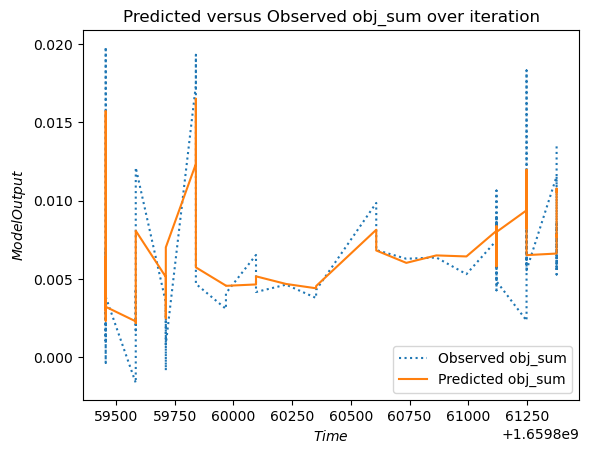

In [31]:
#establish variable for time and plot predicted versus observed obj_sum over time
time1 = torch.tensor(data1['time'].values)
time1 = time1.float()
# time2 = torch.tensor(data2['time'].values)
# time2 = time2.float()

plt.plot(time1, train_y, label=r"Observed obj_sum", linestyle="dotted")
plt.plot(time1, f_mean.detach().numpy(), label=r"Predicted obj_sum")
plt.legend()
plt.ylabel("$Model Output$")
plt.xlabel("$Time$")
_ = plt.title("Predicted versus Observed obj_sum over iteration")

Text(0.5, 0, 'MKB:SYS0:3:VAL')

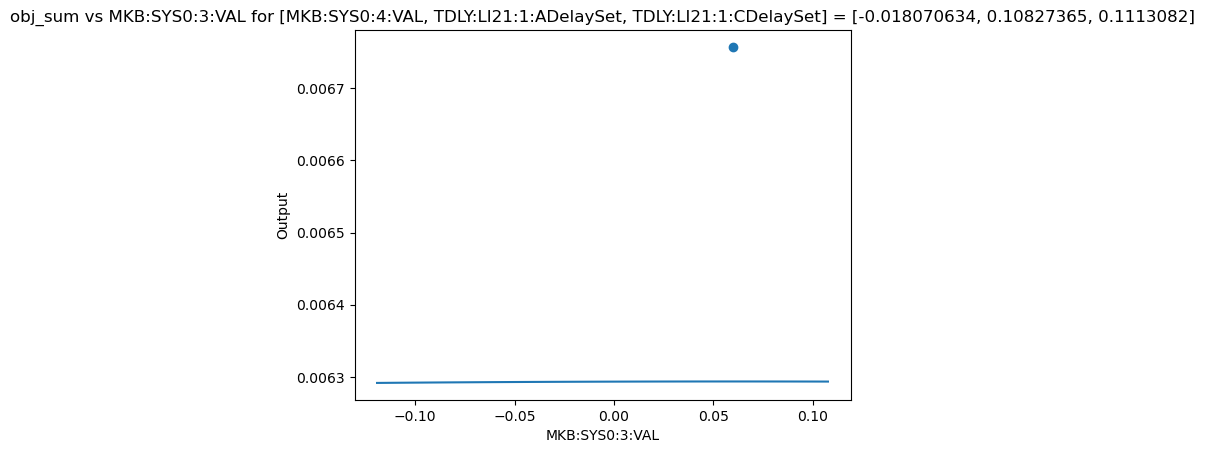

In [19]:
test_xs = train_x[0].repeat(100,1)
test_xs[:,0] = torch.linspace(torch.min(train_x[:,0]), torch.max(train_x[:,0]), 100) 
pred_ys = model.posterior(test_xs).mean
plt.plot(test_xs[:,0].detach().numpy(), pred_ys.detach().numpy())
plt.scatter(train_x[0,0], train_y[0])


plt.title('obj_sum vs MKB:SYS0:3:VAL for [MKB:SYS0:4:VAL, TDLY:LI21:1:ADelaySet, TDLY:LI21:1:CDelaySet] = [' + str(train_x[0,1].detach().numpy()) + ', ' + str(train_x[0,2].detach().numpy()) + ', ' + str(train_x[0,3].detach().numpy()) +']' )
plt.ylabel('Output')
plt.xlabel('MKB:SYS0:3:VAL')


In [20]:
pred_ys.detach().numpy()

array([[0.0062916 ],
       [0.00629165],
       [0.0062917 ],
       [0.00629175],
       [0.0062918 ],
       [0.00629185],
       [0.0062919 ],
       [0.00629195],
       [0.00629199],
       [0.00629204],
       [0.00629208],
       [0.00629213],
       [0.00629217],
       [0.00629222],
       [0.00629226],
       [0.0062923 ],
       [0.00629234],
       [0.00629238],
       [0.00629242],
       [0.00629246],
       [0.0062925 ],
       [0.00629254],
       [0.00629258],
       [0.00629261],
       [0.00629265],
       [0.00629268],
       [0.00629272],
       [0.00629275],
       [0.00629279],
       [0.00629282],
       [0.00629285],
       [0.00629288],
       [0.00629291],
       [0.00629294],
       [0.00629297],
       [0.006293  ],
       [0.00629303],
       [0.00629306],
       [0.00629308],
       [0.00629311],
       [0.00629314],
       [0.00629316],
       [0.00629318],
       [0.00629321],
       [0.00629323],
       [0.00629325],
       [0.00629327],
       [0.006

Text(0.5, 0, 'MKB:SYS0:4:VAL')

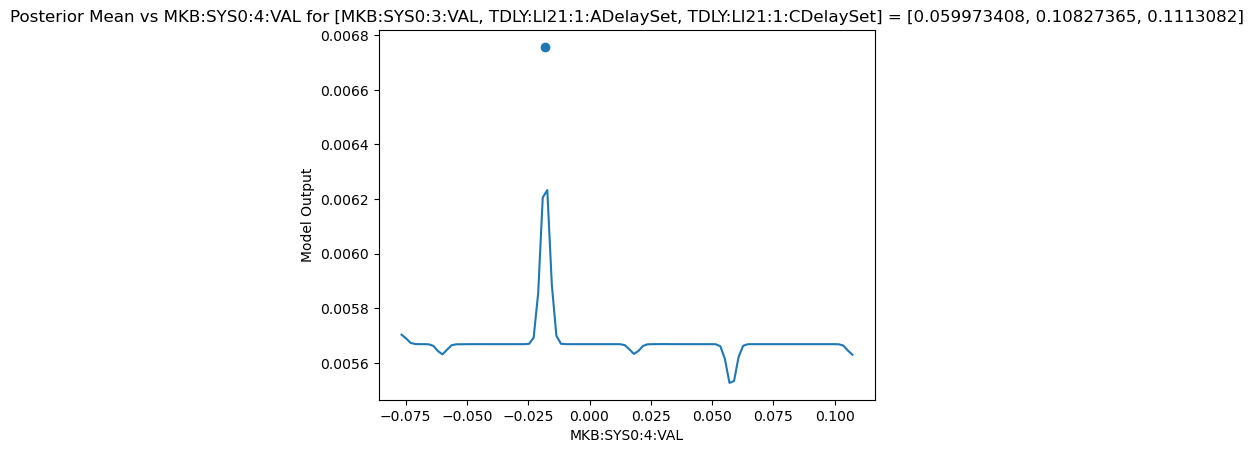

In [21]:
test_xs = train_x[0].repeat(100,1) #duplicate first training point 100 times row-wise
test_xs[:,1] = torch.linspace(torch.min(train_x[:,1]), torch.max(train_x[:,1]), 100) #replace first column with a linspace
pred_ys = model.posterior(test_xs).mean #evaluate model along a 1d subspace of the 4d space.
plt.plot(test_xs[:,1].detach().numpy(), pred_ys.detach().numpy())
plt.scatter(train_x[0,1], train_y[0]) #plot the first training point (which lies somewhere in the 1d subspace)

plt.title('Posterior Mean vs MKB:SYS0:4:VAL for [MKB:SYS0:3:VAL, TDLY:LI21:1:ADelaySet, TDLY:LI21:1:CDelaySet] = [' + str(train_x[0,0].detach().numpy()) + ', ' + str(train_x[0,2].detach().numpy()) + ', ' + str(train_x[0,3].detach().numpy()) +']' )
plt.ylabel('Model Output')
plt.xlabel('MKB:SYS0:4:VAL') 


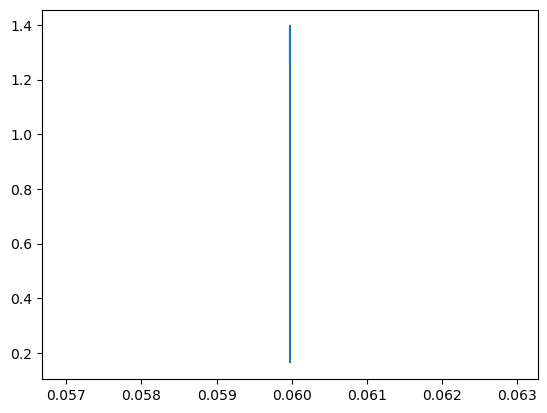

In [22]:
pred_ys = model(test_xs).mean
plt.plot(test_xs[:,0].detach().numpy(), pred_ys.detach().numpy())

In [23]:
str(train_x[0,1:])

'tensor([-0.0181,  0.1083,  0.1113])'

Text(0.5, 0, 'TDLY:LI21:1:ADelaySet')

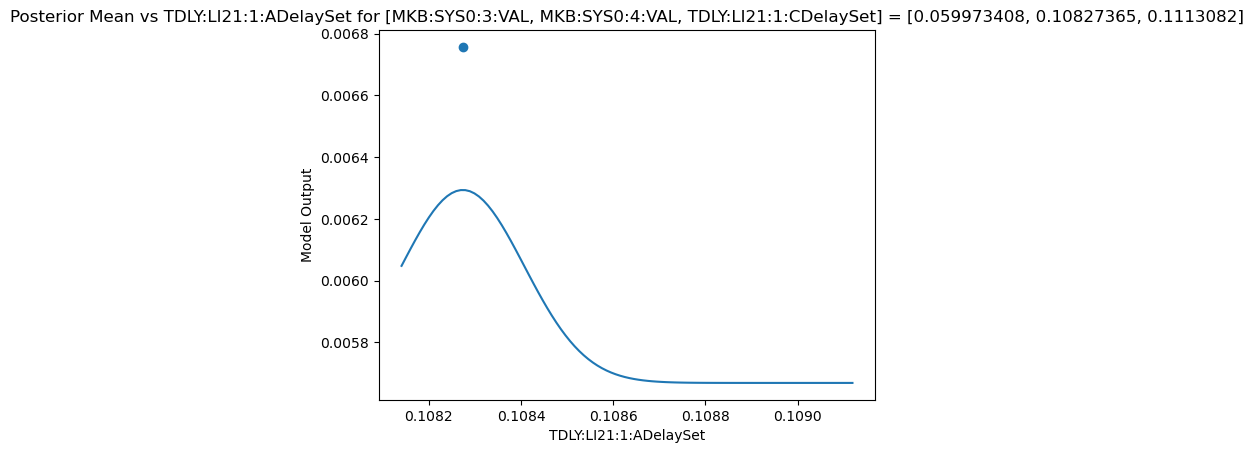

In [24]:
test_xs = train_x[0].repeat(100,1)
test_xs[:,2] = torch.linspace(torch.min(train_x[:,2]), torch.max(train_x[:,2]), 100) 
pred_ys = model.posterior(test_xs).mean
plt.plot(test_xs[:,2].detach().numpy(), pred_ys.detach().numpy())
plt.scatter(train_x[0,2], train_y[0])

plt.title('Posterior Mean vs TDLY:LI21:1:ADelaySet for [MKB:SYS0:3:VAL, MKB:SYS0:4:VAL, TDLY:LI21:1:CDelaySet] = [' + str(train_x[0,0].detach().numpy()) + ', ' + str(train_x[0,2].detach().numpy()) + ', ' + str(train_x[0,3].detach().numpy()) +']' )
plt.ylabel('Model Output')
plt.xlabel('TDLY:LI21:1:ADelaySet') 

Text(0.5, 0, 'TDLY:LI21:1:CDelaySet')

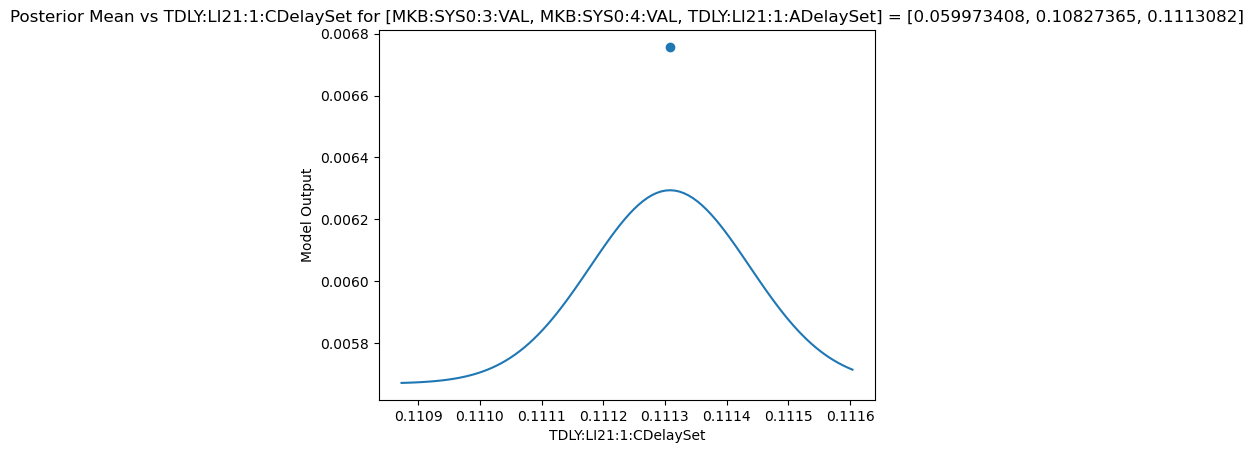

In [25]:
test_xs = train_x[0].repeat(100,1)
test_xs[:,3] = torch.linspace(torch.min(train_x[:,3]), torch.max(train_x[:,3]), 100) 
pred_ys = model.posterior(test_xs).mean
plt.plot(test_xs[:,3].detach().numpy(), pred_ys.detach().numpy())
plt.scatter(train_x[0,3], train_y[0])

plt.title('Posterior Mean vs TDLY:LI21:1:CDelaySet for [MKB:SYS0:3:VAL, MKB:SYS0:4:VAL, TDLY:LI21:1:ADelaySet] = [' + str(train_x[0,0].detach().numpy()) + ', ' + str(train_x[0,2].detach().numpy()) + ', ' + str(train_x[0,3].detach().numpy()) +']' )
plt.ylabel('Model Output')
plt.xlabel('TDLY:LI21:1:CDelaySet') 

In [26]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x.float()))

ValueError: 'x' is not 1-dimensional

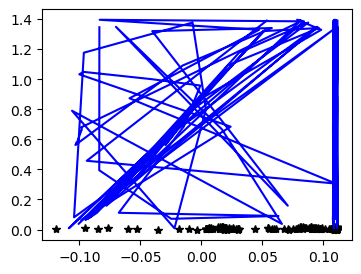

In [27]:
# plotting the training and testing
with torch.no_grad():
    # initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])